# Customer Segmentation using RFM Analysis
In this notebook, we analyze customer behavior using the RFM (Recency, Frequency, Monetary) framework.  
The RFM dataset generated from the previous data cleaning process will be used to identify customer segments and understand spending patterns.

This analysis helps classify customers based on their purchasing behavior and provides insights for targeted marketing strategies.

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

In [41]:
rfm = pd.read_pickle('../data/processed/pkl_rfm_data.pkl')
rfm.head()

,Recency,Frequency,Monetary
Customer_ID,,,
10000.0,103,4,5007.566357
10001.0,105,5,8136.462824
10002.0,95,5,4104.013951
10003.0,228,2,2340.496447
10004.0,31,2,2356.516683


## RFM Score
RFM scores were assigned using quantile-based thresholds at 0.20, 0.40, 0.60, and 0.80.  

For each metric:
- **Recency** was scored in reverse (lower recency = better score).  
  Customers in the lowest 20% of Recency received a score of 5, and those above the 80% threshold received a score of 1.
- **Frequency** and **Monetary** were scored normally (higher values = better score).  
  Customers in the lowest 20% received a score of 1, and those above the 80% threshold received a score of 5.

This scoring method standardizes customer behavior into comparable RFM scores, preparing the dataset for segmentation.

In [42]:
quantiles = rfm.quantile(q=[0.20, 0.40, 0.6, 0.8])

def RScore(x, p, d):
    if p == 'Recency':
        if x <= d[p][0.20]:
            return 5
        elif x <= d[p][0.40]:
            return 4
        elif x <= d[p][0.60]:
            return 3
        elif x <= d[p][0.8]:
            return 2
        else:
            return 1
    else:
        if x <= d[p][0.20]:
            return 1
        elif x <= d[p][0.40]:
            return 2
        elif x <= d[p][0.60]:
            return 3
        elif x <= d[p][0.8]:
            return 4
        else:
            return 5

In [43]:
rfm['R'] = rfm['Recency'].apply(RScore, args=('Recency', quantiles))
rfm['F'] = rfm['Frequency'].apply(RScore, args=('Frequency', quantiles))
rfm['M'] = rfm['Monetary'].apply(RScore, args=('Monetary', quantiles))

rfm.head()


,Recency,Frequency,Monetary,R,F,M
Customer_ID,,,,,,
10000.0,103,4,5007.566357,2,3,4
10001.0,105,5,8136.462824,2,4,5
10002.0,95,5,4104.013951,3,4,3
10003.0,228,2,2340.496447,1,1,2
10004.0,31,2,2356.516683,4,1,2


In [44]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86485 entries, 10000.0 to 99999.0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    86485 non-null  int64  
 1   Frequency  86485 non-null  int64  
 2   Monetary   86485 non-null  float64
 3   R          86485 non-null  int64  
 4   F          86485 non-null  int64  
 5   M          86485 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 4.6 MB


## Creating RFM Segment and RFM Score
An RFM segment was created by combining the individual Recency, Frequency, and Monetary scores into a single string (e.g., "543", "322").  
This segment provides a quick way to identify customer behavior patterns based on their R, F, and M scoring.

Additionally, an overall **RFM Score** was calculated by summing the three scores.  
This combined score helps categorize customers into broader groups for further segmentation and analysis.

In [45]:
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
Customer_ID,,,,,,,,
10000.0,103,4,5007.566357,2,3,4,234,9
10001.0,105,5,8136.462824,2,4,5,245,11
10002.0,95,5,4104.013951,3,4,3,343,10
10003.0,228,2,2340.496447,1,1,2,112,4
10004.0,31,2,2356.516683,4,1,2,412,7


## Assigning Customer Segments
Customer segments were assigned based on the total RFM Score using predefined score ranges.  
Each score range corresponds to a specific customer group, such as Champions, Loyal Customers, or At Risk customers.

This categorization helps identify customer behavior patterns and supports targeted marketing strategies.

In [46]:
def assign_segment(score):
    if score >= 13:
        return "Champions"
    elif score >= 10:
        return "Loyal Customers"
    elif score >= 8:
        return "Potential Loyalists"
    elif score >= 6:
        return "At Risk"
    elif score >= 4:
        return "Hibernating"
    else:
        return "Lost Customers"


In [47]:
rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)


In [48]:
rfm['Segment'].value_counts()

Segment
Loyal Customers        21559
Potential Loyalists    16332
At Risk                16207
Hibernating            13791
Champions              12328
Lost Customers          6268
Name: count, dtype: int64

The segmentation results show that the majority of customers fall into the **Loyal Customers**, **Potential Loyalists**, and **At Risk** categories.  
This indicates a strong core of active customers, but also highlights a significant portion at risk of churn.  
Meanwhile, the **Champions** represent highly valuable customers, and the **Lost Customers** group is relatively smaller compared to other segments.

In [49]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
Customer_ID,,,,,,,,,
10000.0,103,4,5007.566357,2,3,4,234,9,Potential Loyalists
10001.0,105,5,8136.462824,2,4,5,245,11,Loyal Customers
10002.0,95,5,4104.013951,3,4,3,343,10,Loyal Customers
10003.0,228,2,2340.496447,1,1,2,112,4,Hibernating
10004.0,31,2,2356.516683,4,1,2,412,7,At Risk


## Results

In [50]:
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
Customer_ID,,,,,,,,,
10000.0,103,4,5007.566357,2,3,4,234,9,Potential Loyalists
10001.0,105,5,8136.462824,2,4,5,245,11,Loyal Customers
10002.0,95,5,4104.013951,3,4,3,343,10,Loyal Customers
10003.0,228,2,2340.496447,1,1,2,112,4,Hibernating
10004.0,31,2,2356.516683,4,1,2,412,7,At Risk


In [51]:
rfm_segment_profile = rfm.groupby('Segment').agg({'R' : 'mean',
                            'F' : 'mean',
                            'M' : 'mean',
                            'Recency': 'mean',
                            'Frequency': 'mean',
                            'Monetary': 'mean'})
rfm_segment_profile

,R,F,M,Recency,Frequency,Monetary
Segment,,,,,,
At Risk,2.719936,1.566730,2.236379,104.793052,2.445857,2971.701165
Champions,4.438514,4.583306,4.772226,27.838660,6.084442,9193.318131
Hibernating,1.705243,1.136611,1.678776,171.630411,1.792763,2046.622261
Lost Customers,1.000000,1.000000,1.000000,257.282387,1.295150,858.085701
Loyal Customers,3.677768,3.300153,3.959553,56.572151,4.341760,6305.801496
Potential Loyalists,3.208854,2.251163,3.036615,78.691710,3.233713,4342.732805


In [52]:
segment_counts = rfm.groupby('Segment').size().reset_index(name = 'Customer Count')
segment_counts

,Segment,Customer Count
0,At Risk,16207
1,Champions,12328
2,Hibernating,13791
3,Lost Customers,6268
4,Loyal Customers,21559
5,Potential Loyalists,16332


In [53]:
total = len(rfm)
segment_counts['Percentage'] = segment_counts['Customer Count']/total
segment_counts = segment_counts.sort_values(by='Percentage', ascending=False)
segment_counts

,Segment,Customer Count,Percentage
4,Loyal Customers,21559,0.249280
5,Potential Loyalists,16332,0.188842
0,At Risk,16207,0.187397
2,Hibernating,13791,0.159461
1,Champions,12328,0.142545
3,Lost Customers,6268,0.072475


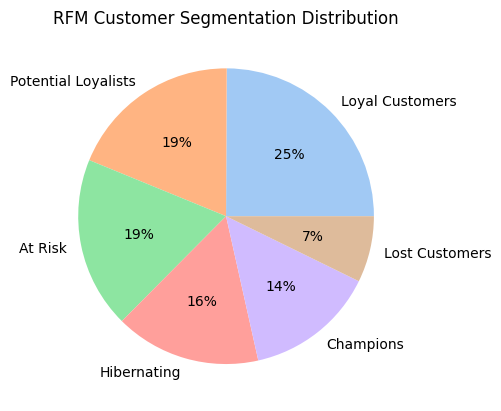

In [54]:
data = segment_counts['Customer Count']
labels = segment_counts['Segment']

colors = sns.color_palette('pastel')[0:6]

plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.title('RFM Customer Segmentation Distribution')
plt.show()

## Saving the Segmented RFM Dataset
The final RFM dataset, including the RFM scores and assigned customer segments, was saved for further analysis and reporting.

In [ ]:
rfm.to_csv('../data/processed/rfm_segmentation.csv')
rfm.to_pickle('../data/processed/pkl_rfm_segmnetation.csv')